# Group Project, project_5, Finding Danger Spots in the US amidst COVID-19
Matt Paterson, hello@hireMattPaterson.com

## Looking at data around natural disasters, what risk does each geographic area have?

**In this project we analyze COVID-19 data, data around natural disasters, and other factors to identify hot spots that may or may not be at a higher risk than other geographic regions in 2020 and beyond.  We will create an overlay map that allows a user to drill down by location and/or by type of threat (ie Earthquake, Hurricane, Tornado, COVID-19 outbreak, etc) to see what the relative risk of each area may be.**

***THIS NOTEBOOK is an early step in to the full project, and will specifically look at a dataset that was too lean to be used in our full group project.  I'll walk through the steps needed here to create a linear regression model.***

## Data 

This notebook is created to pull data specifically relating to the COVID-19 pandemic.  I will pull in a dataset and run a preliminary EDA and model on it.  

For this particular notebook, it was not necessary to create a web scraper or an API-interactive function as the data is already organized in a git repository thanks to Johns Hopkins University. However as you'll see below this dataset is not robust enough for our purposes.

In [1]:
import pandas as pd                 # import the pandas library
import numpy as np                  # import the numpy library
import matplotlib.pyplot as plt     # import the matplotlib library
import seaborn as sns               # import the seaborn library

In [4]:
# ENTER YESTERDAY'S DATE as a string below IN THE FORM MM-DD-YYYY
yesterday = '07-31-2020'

path_to_home = '../'
path_to_subsets = path_to_home + 'data/COVID-19/csse_covid_19_data/'
daily_report = path_to_subsets + 'csse_covid_19_daily_reports_us/' + yesterday + '.csv'

## Read in a csv of the dataset

In [5]:
df = pd.read_csv(daily_report)

In [6]:
# Look at the first five rows of data to get a general idea of what the dataset looks like
df.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-08-01 04:36:46,32.3182,-86.9023,87723,1580,35401.0,50742.0,1,1789.102390,689467.0,10521.0,1.801124,84000001,USA,14061.615052,11.993434
1,Alaska,US,2020-08-01 04:36:46,61.3707,-152.4044,2990,23,898.0,2069.0,2,408.724002,233106.0,NaN,0.769231,84000002,USA,31864.888694,NaN
2,American Samoa,US,2020-08-01 04:36:46,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,1037.0,NaN,NaN,16,ASM,1863.733578,NaN
3,Arizona,US,2020-08-01 04:36:46,33.7298,-111.4312,174010,3694,22714.0,147602.0,4,2390.668575,933743.0,11260.0,2.122867,84000004,USA,12828.400939,6.470892
4,Arkansas,US,2020-08-01 04:36:46,34.9697,-92.3731,42511,453,35413.0,6645.0,5,1408.673327,503469.0,2852.0,1.065607,84000005,USA,16683.290234,6.708852


In [13]:
# look at the pandas.DataFrame.shape attribute to see the (rows, columns) that make up our dataset
df.shape

(58, 18)

## Exploratory Data Analysis
Fifty-eight rows is not a lot of data. This dataset tells the story of the US States and territories. This level of data will not satisfy the requirements of our data problem. We'll need to drill down to the local level--the county level at the least, zip code or even neighborhood at the best--in order to learn what we need to learn to make our interactive heatmaps relevant.

For this notebook I'll continue the EDA, visualizations, and investigations in hopes that this same methodology will scale to the correct dataset.

1. Identify any null values within the dataset 
2. Clear or convert any columns that are non-numeric 
3. Graph or plot as much of the data as is needed to understand it

In [11]:
# Show all null values
df.isna().sum()

Province_State           0
Country_Region           0
Last_Update              0
Lat                      2
Long_                    2
Confirmed                0
Deaths                   0
Recovered               10
Active                   0
FIPS                     0
Incident_Rate            2
People_Tested            2
People_Hospitalized     21
Mortality_Rate           1
UID                      0
ISO3                     0
Testing_Rate             2
Hospitalization_Rate    21
dtype: int64

We see that we have null values in the following rows:
<ul>
    <li>Latitude</li>
    <li>Longitude</li>
    <li>Recovered</li>
    <li>Incident_Rate</li>
    <li>People_Tested</li>
    <li>People_Hospitalized</li>
    <li>Mortality_Rate</li>
    <li>Testing_Rate</li>
    <li>Hospitalization_Rate</li>
</ul>

Were we to use this dataset, we'd want to decide which of these columns are unnecessary to our problem statement, and which of those that are relevant can be imputed or predicted before we proceed to model the data

In [14]:
# List out the datatypes
df.dtypes

Province_State           object
Country_Region           object
Last_Update              object
Lat                     float64
Long_                   float64
Confirmed                 int64
Deaths                    int64
Recovered               float64
Active                  float64
FIPS                      int64
Incident_Rate           float64
People_Tested           float64
People_Hospitalized     float64
Mortality_Rate          float64
UID                       int64
ISO3                     object
Testing_Rate            float64
Hospitalization_Rate    float64
dtype: object

Four of our columns are non-numeric data, including Country_Region, Provice_State, Last_Update, and ISO3. 

The ISO3 is simply a three letter abbreviation of the region or country, so we can drop that feature from our model as it gives us no information of interest. The Country_Region is always the US, so that's not helpful here either.  Last_Update may prove relevant in a future iteration, and we could convert that column to datatime.  Finally Province_State can be converted to an index column in this particular dataset.

In [15]:
df.Country_Region.value_counts()

US    58
Name: Country_Region, dtype: int64

In [16]:
df.Last_Update.value_counts()

2020-08-01 04:36:46    58
Name: Last_Update, dtype: int64

It turns out that in this entry, all of the Last_Update values are the same, so it's clearly not needed for this particular model.

In [19]:
df.rename(columns={'Province_State': 'State'}, inplace=True)
df.set_index('State', inplace=True)
df.head()

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
State,,,,,,,,,,,,,,,,,
Alabama,US,2020-08-01 04:36:46,32.3182,-86.9023,87723,1580,35401.0,50742.0,1,1789.102390,689467.0,10521.0,1.801124,84000001,USA,14061.615052,11.993434
Alaska,US,2020-08-01 04:36:46,61.3707,-152.4044,2990,23,898.0,2069.0,2,408.724002,233106.0,NaN,0.769231,84000002,USA,31864.888694,NaN
American Samoa,US,2020-08-01 04:36:46,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,1037.0,NaN,NaN,16,ASM,1863.733578,NaN
Arizona,US,2020-08-01 04:36:46,33.7298,-111.4312,174010,3694,22714.0,147602.0,4,2390.668575,933743.0,11260.0,2.122867,84000004,USA,12828.400939,6.470892
Arkansas,US,2020-08-01 04:36:46,34.9697,-92.3731,42511,453,35413.0,6645.0,5,1408.673327,503469.0,2852.0,1.065607,84000005,USA,16683.290234,6.708852


And as mentioned, we can drop the above columns as well as  a few others such as FIPS and UID

In [20]:
df.drop(columns=['FIPS', 'UID', 'Country_Region', 'Last_Update', 'ISO3'], inplace=True)

In [21]:
df.head()

,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
State,,,,,,,,,,,,
Alabama,32.3182,-86.9023,87723,1580,35401.0,50742.0,1789.102390,689467.0,10521.0,1.801124,14061.615052,11.993434
Alaska,61.3707,-152.4044,2990,23,898.0,2069.0,408.724002,233106.0,NaN,0.769231,31864.888694,NaN
American Samoa,-14.2710,-170.1320,0,0,NaN,0.0,0.000000,1037.0,NaN,NaN,1863.733578,NaN
Arizona,33.7298,-111.4312,174010,3694,22714.0,147602.0,2390.668575,933743.0,11260.0,2.122867,12828.400939,6.470892
Arkansas,34.9697,-92.3731,42511,453,35413.0,6645.0,1408.673327,503469.0,2852.0,1.065607,16683.290234,6.708852


In [23]:
# To be sure that we only have numeric columns left:
df.dtypes

Lat                     float64
Long_                   float64
Confirmed                 int64
Deaths                    int64
Recovered               float64
Active                  float64
Incident_Rate           float64
People_Tested           float64
People_Hospitalized     float64
Mortality_Rate          float64
Testing_Rate            float64
Hospitalization_Rate    float64
dtype: object

In [29]:
# Show the columns that have null values for lat and long:
df[df.Lat.isna() | df.Long_.isna()]

,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
State,,,,,,,,,,,,
Diamond Princess,NaN,NaN,49,0,NaN,49.0,NaN,NaN,NaN,0.000000,NaN,NaN
Grand Princess,NaN,NaN,103,3,NaN,100.0,NaN,NaN,NaN,2.912621,NaN,NaN


Rather than states or territories, the Grand Princess and Diamond Princess are cruise ships that do not have a constant lattitude and longitude.  They also are not relevant to our regression model as they have much different environmental factors than a state or territory would.  We can drop those rows from our model.

In [31]:
df.drop(['Diamond Princess', 'Grand Princess'], inplace=True)
df.shape

(56, 12)

In [32]:
df.isna().sum()

Lat                      0
Long_                    0
Confirmed                0
Deaths                   0
Recovered                8
Active                   0
Incident_Rate            0
People_Tested            0
People_Hospitalized     19
Mortality_Rate           1
Testing_Rate             0
Hospitalization_Rate    19
dtype: int64

In [33]:
df[df.Recovered.isna()]

,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
State,,,,,,,,,,,,
American Samoa,-14.2710,-170.1320,0,0,NaN,0.0,0.000000,1037.0,NaN,NaN,1863.733578,NaN
California,36.1162,-119.6816,500556,9214,NaN,491342.0,1266.838365,7811041.0,NaN,1.840753,19768.670064,NaN
Florida,27.7663,-81.6868,470386,6843,NaN,463543.0,2190.109694,3628088.0,26905.0,1.454763,16892.319708,5.719771
Georgia,33.0406,-83.6431,186352,3752,NaN,182600.0,1755.152828,1574687.0,18689.0,2.013394,14831.160066,10.028870
Illinois,40.3495,-88.9861,180115,7692,NaN,172423.0,1421.382136,2700849.0,NaN,4.270605,21313.819064,NaN
Missouri,38.4561,-92.2884,50616,1265,NaN,49351.0,824.710286,686773.0,NaN,2.499210,11189.915385,NaN
Puerto Rico,18.2208,-66.5901,16781,219,NaN,16562.0,572.064984,322753.0,NaN,1.305047,11002.663114,NaN
Washington,47.4009,-121.4905,55803,1564,NaN,54239.0,732.813974,973654.0,5568.0,2.802717,12786.180975,9.977958


We don't have recovery data from eight states and territories.  We know from reporting that the availability of and access to proper testing for COVID-19 have been less than consistent accross the United States since the start of the virus, and so the recovered number is less than an accurate potrayal of the reality.  If we keep it in our model at all, it could produce misleading predictions.  We'll drop it.  

In [34]:
df[df.Mortality_Rate.isna()]

,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
State,,,,,,,,,,,,
American Samoa,-14.271,-170.132,0,0,NaN,0.0,0.0,1037.0,NaN,NaN,1863.733578,NaN


While Mortality Rate might have a similar problem to the 'Recovered' column, the only row with null data is from American Samoa, where zero cases or deaths have been reported.  Instead of deleting the 'Mortality_Rate' column, we'll delete the 'American Samoa' row.

In [41]:
df.drop('American Samoa', inplace=True)
df.drop(columns=('Recovered'), inplace=True)
df.shape

(55, 11)

In [42]:
df.isna().sum()

Lat                      0
Long_                    0
Confirmed                0
Deaths                   0
Active                   0
Incident_Rate            0
People_Tested            0
People_Hospitalized     18
Mortality_Rate           0
Testing_Rate             0
Hospitalization_Rate    18
dtype: int64

Now the columns that we have left that are empty are the hospitalization columns--for the rate and the number of people hospitalized.  These will be the rows that we will predict.

The Hospitalization_Rate is an aggregate column, and so that column will neither be predicted nor will it be used as an input feature in to our linear regression model.  From here, we'll take a quick look at feature engineering and then we can split our data into a training, validation, and testing set before running the model.

It should be noted that with so few inputs, our model will be heavily affected by statistical bias.  Bias in its simplest terms is caused by a lack of information being given to the model. Bias occurs when we try to predict the outcome of an event without the added nuance of all factors that can contribute to it. The oppostie of statistical bias is statistical variance, which can cause over-fitting of a model in the case of an overabundance of input data.  Over-fitting is when we make our model so good at predicting things based on its training set, that it has a hard time being accurate in its predictions on new unseen data.  We strive for a balance in the bias-variance tradeoff, however with only 55 datapoints to start with, 18 of which are completely unknown, it will be a challenge to get a good prediction model running.

## Feature Engineering

Before we create new columns to use to help train our model, let's take a look at the empty columns that need to be predicted in the end.

In [49]:
test_df = df[['People_Hospitalized', 'Hospitalization_Rate', 'Confirmed', 'Deaths']][df.People_Hospitalized.isna()]
test_df

,People_Hospitalized,Hospitalization_Rate,Confirmed,Deaths
State,,,,
Alaska,NaN,NaN,2990,23
California,NaN,NaN,500556,9214
Delaware,NaN,NaN,14788,585
District of Columbia,NaN,NaN,12057,584
Guam,NaN,NaN,356,5
Illinois,NaN,NaN,180115,7692
Iowa,NaN,NaN,44753,872
Louisiana,NaN,NaN,116280,3949
Michigan,NaN,NaN,90574,6450


In [68]:
test_df = df[df.People_Hospitalized.isna()]
test_df.columns

Index(['Lat', 'Long_', 'Confirmed', 'Deaths', 'Active', 'Incident_Rate',
       'People_Tested', 'People_Hospitalized', 'Mortality_Rate',
       'Testing_Rate', 'Hospitalization_Rate'],
      dtype='object')

In [62]:
# Create a train_df by dropping the test_df from df
train_df = df.drop(test_df.index)

In [101]:
# Pull data from Wikipedia showing the population of each state or territory
# Create a Testing_Rate column that is the percentage of the population that has been tested
# Create a Positive_tet_Rate that is the number of positive tests / number of tests given

## Modeling

1. Split up the remaining 37 rows of data from our training dataset into a training and a validation set
2. Fit a linear regression model to the data and find the Root Mean Sqared Error of the model
3. Play with the features of the model to lower the RMSE
4. Run the model on our testing data to predict the hospitalization rate of people in our test states

In [87]:
# import libraries
from sklearn.linear_model          import LinearRegression
from sklearn.metrics               import r2_score, mean_squared_error
from sklearn.model_selection       import train_test_split


In [58]:
train_df.columns

Index(['Lat', 'Long_', 'Confirmed', 'Deaths', 'Active', 'Incident_Rate',
       'People_Tested', 'People_Hospitalized', 'Mortality_Rate',
       'Testing_Rate', 'Hospitalization_Rate'],
      dtype='object')

In [156]:
# Various combinations of features to be used in the model:
feat_0 = train_df.drop(columns=(['People_Hospitalized', 'Hospitalization_Rate'])).columns
feat_1 = train_df[['Confirmed', 'Deaths', 'Active', 'Incident_Rate', 'People_Tested', 'Testing_Rate']].columns
feat_2 = train_df[['Deaths', 'Active', 'Incident_Rate']].columns

# Toggle this to change our model predictions below
features = feat_1

In [191]:
def model_results(feats, y=train_df['People_Hospitalized']):
    '''
    returns:      a Linear Regression model
    prints:       a printout of the RMSE
    feats         the features list to use on this particular model
    y:            a list of the targets for training and validation
    WARNING: This function as written only works in this notebook, must make adjustments 
    '''
    import pandas as pd
    import numpy as np
    
    from sklearn.linear_model          import LinearRegression
    from sklearn.metrics               import mean_squared_error
    from sklearn.model_selection       import train_test_split
    
    # Create the test-train split
    X = train_df[feats]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
    
    # Create and fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Find and printout RMSE
    val_predictions = model.predict(X_val)
    RMSE = (mean_squared_error(y_val, model.predict(X_val)))**(1/2)
    print(f"The Root Mean Squared Error for this model is {round(RMSE,2)}, meaning that it's accurate \
give or take up to {round(RMSE, 0)} people hospitalized in a given state, or so.")
    
    return model

In [192]:
print("feature set 1:  ")
model_results(feat_0)
print("feature set 2:  ")
model_results(feat_1)
print("feature set 3:  ")
model_results(feat_2)

feature set 1:  
The Root Mean Squared Error for this model is 3258.83, meaning that it's accurate give or take up to 3259.0 people hospitalized in a given state, or so.
feature set 2:  
The Root Mean Squared Error for this model is 1060.29, meaning that it's accurate give or take up to 1060.0 people hospitalized in a given state, or so.
feature set 3:  
The Root Mean Squared Error for this model is 1360.96, meaning that it's accurate give or take up to 1361.0 people hospitalized in a given state, or so.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Try out the new function on a new feature set

In [123]:
second_model = model_results()

The Root Mean Squared Error for this model is 1060.29, meaning that it's accurate give or take up to 1060.0 people hospitalized in a given state, or so.


Now predict the missing states in the test dataframe:

In [127]:
X_test = test_df[features]
test_df['People_Hospitalized'] = second_model.predict(X_test)
test_df[['Confirmed', 'Deaths', 'Active', 'Incident_Rate', 'People_Tested', 'People_Hospitalized']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Confirmed,Deaths,Active,Incident_Rate,People_Tested,People_Hospitalized
State,,,,,,
Alaska,2990,23,2069.0,408.724002,233106.0,-3770.055968
California,500556,9214,491342.0,1266.838365,7811041.0,79543.920217
Delaware,14788,585,6024.0,1518.643121,181047.0,1003.805608
District of Columbia,12057,584,1657.0,1708.397745,188741.0,-569.945258
Guam,356,5,47.0,216.770485,21882.0,-1819.478327
Illinois,180115,7692,172423.0,1421.382136,2700849.0,31799.022098
Iowa,44753,872,11303.0,1418.447134,474412.0,2455.484926
Louisiana,116280,3949,38085.0,2501.293884,1342243.0,9167.245795
Michigan,90574,6450,26622.0,906.931981,1844447.0,20203.116551


## Plot the results

In [139]:
result_df = pd.concat([train_df, test_df])

In [144]:
result_df.sort_values(by=['People_Hospitalized'], inplace=True)

Text(0.5, 1.0, 'People Hospitalized by State')

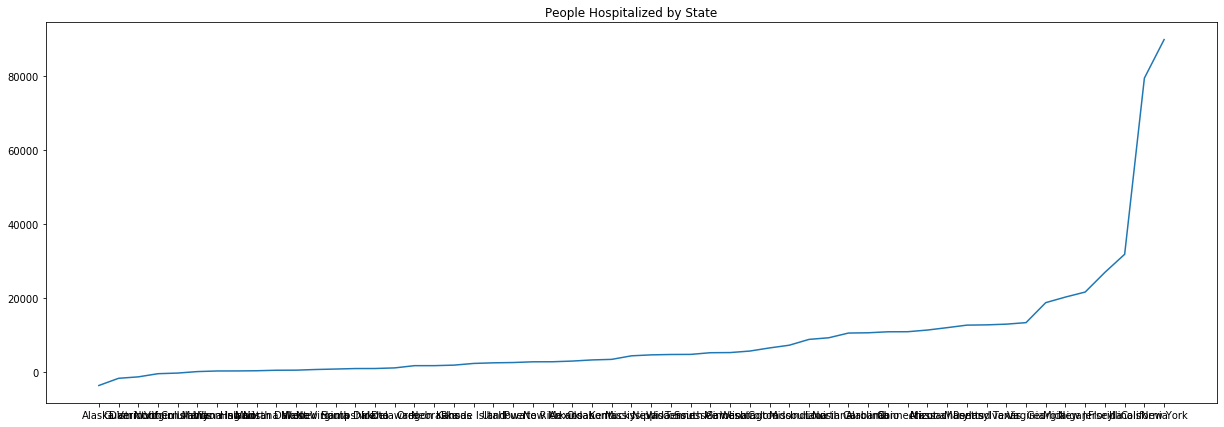

In [145]:
plt.figure(figsize=(21, 7))

plt.plot(result_df.index, result_df.People_Hospitalized);

plt.title('People Hospitalized by State')

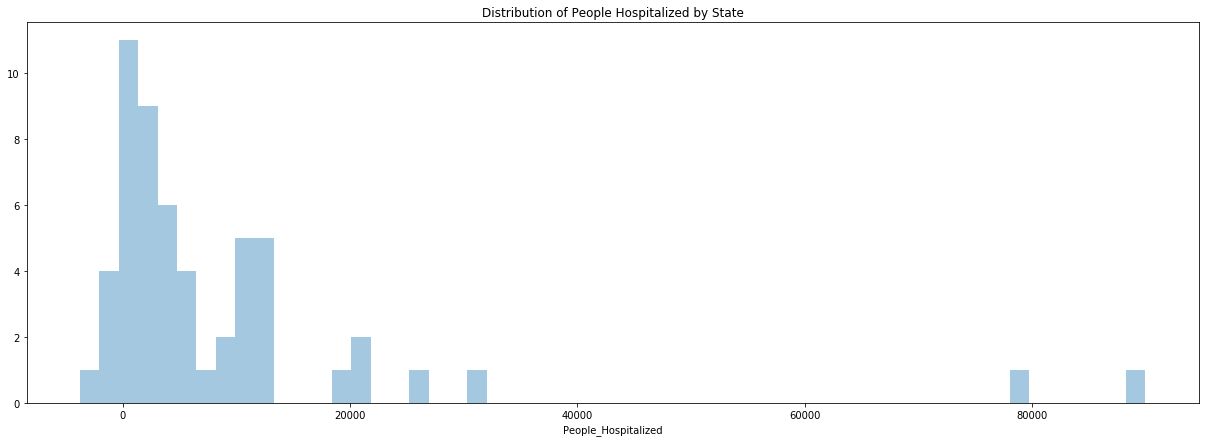

In [149]:
plt.figure(figsize=(21, 7))

sns.distplot(result_df['People_Hospitalized'], kde=False, bins = 55)

plt.title('Distribution of People Hospitalized by State');

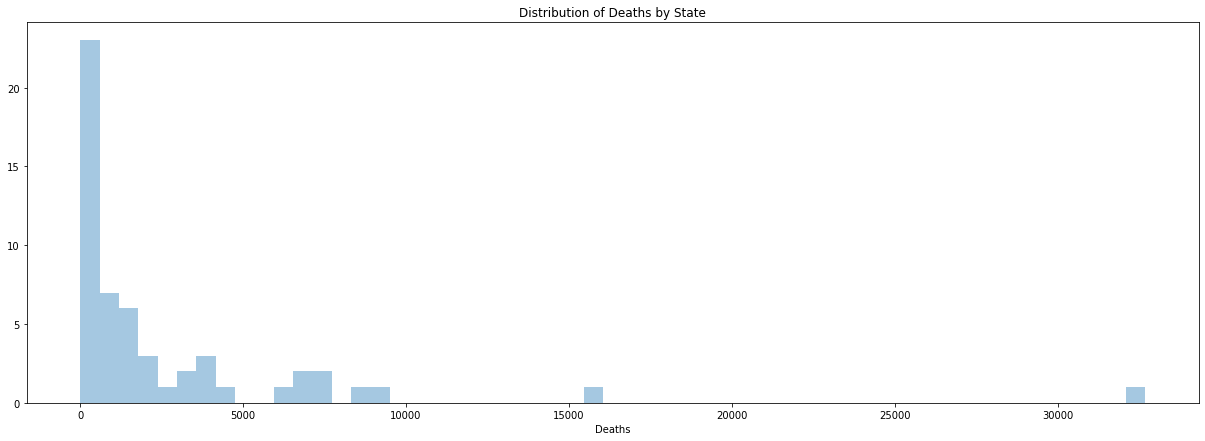

In [150]:
plt.figure(figsize=(21, 7))

sns.distplot(result_df['Deaths'], kde=False, bins = 55)

plt.title('Distribution of Deaths by State');

The coefficients above show us which features seem to indicate major or minor effects on the fit of the model

## Predict the Hospitalization numbers in the test states:

In [152]:
X_test = test_df[features]

test_df['People_Hospitalized'] = second_model.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
test_df

,Lat,Long_,Confirmed,Deaths,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
State,,,,,,,,,,,
Alaska,61.3707,-152.4044,2990,23,2069.0,408.724002,233106.0,-3770.055968,0.769231,31864.888694,-3.270123
California,36.1162,-119.6816,500556,9214,491342.0,1266.838365,7811041.0,79543.920217,1.840753,19768.670064,0.155406
Delaware,39.3185,-75.5071,14788,585,6024.0,1518.643121,181047.0,1003.805608,3.955910,18592.492637,0.013994
District of Columbia,38.8974,-77.0268,12057,584,1657.0,1708.397745,188741.0,-569.945258,4.843659,26743.360600,-0.275779
Guam,13.4443,144.7937,356,5,47.0,216.770485,21882.0,-1819.478327,1.404494,13324.077964,21.967367
Illinois,40.3495,-88.9861,180115,7692,172423.0,1421.382136,2700849.0,31799.022098,4.270605,21313.819064,0.169714
Iowa,42.0115,-93.2105,44753,872,11303.0,1418.447134,474412.0,2455.484926,1.948473,15036.496813,0.065423
Louisiana,31.1695,-91.8678,116280,3949,38085.0,2501.293884,1342243.0,9167.245795,3.396113,28872.929194,0.073481
Michigan,43.3266,-84.5361,90574,6450,26622.0,906.931981,1844447.0,20203.116551,7.121249,18468.743470,0.187902


In [154]:
test_df['Hospitalization_Rate'] = test_df['People_Hospitalized'] / test_df['Confirmed']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [155]:
test_df

,Lat,Long_,Confirmed,Deaths,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
State,,,,,,,,,,,
Alaska,61.3707,-152.4044,2990,23,2069.0,408.724002,233106.0,-3770.055968,0.769231,31864.888694,-1.260888
California,36.1162,-119.6816,500556,9214,491342.0,1266.838365,7811041.0,79543.920217,1.840753,19768.670064,0.158911
Delaware,39.3185,-75.5071,14788,585,6024.0,1518.643121,181047.0,1003.805608,3.955910,18592.492637,0.067880
District of Columbia,38.8974,-77.0268,12057,584,1657.0,1708.397745,188741.0,-569.945258,4.843659,26743.360600,-0.047271
Guam,13.4443,144.7937,356,5,47.0,216.770485,21882.0,-1819.478327,1.404494,13324.077964,-5.110894
Illinois,40.3495,-88.9861,180115,7692,172423.0,1421.382136,2700849.0,31799.022098,4.270605,21313.819064,0.176548
Iowa,42.0115,-93.2105,44753,872,11303.0,1418.447134,474412.0,2455.484926,1.948473,15036.496813,0.054867
Louisiana,31.1695,-91.8678,116280,3949,38085.0,2501.293884,1342243.0,9167.245795,3.396113,28872.929194,0.078838
Michigan,43.3266,-84.5361,90574,6450,26622.0,906.931981,1844447.0,20203.116551,7.121249,18468.743470,0.223056


## Issues that should be brought up:

The Mortality Rate and Hospitalization Rate in this data is inherenlty flawed as it is based upon the raw testing numbers in a given state. In order to do an apples to apples comparisson between the states, we need to really look at the hospitalization number divided by the population of the state.  The same should be done with the raw number of deaths. Simply basing any data on the the testing data can give a false sense of gloom or a false sense of security to any local population. We do have the testing rate, which is the number of people tested per 100,000 people, and we should use this number along with the state's population numbers to find our more tangible comparative numbers.

A better look at the data should be done by taking in to account the populations of each area and how the raw death and raw hospitalization numbers compare. From there we can do comparative analysis on population density, age, socio-econmic issues, and relative health prior to the pandemic. We have Incidents_Rate, but that only takes in to account the total positve tests / total population (it's actually cases per 100,000 people) and does not take in more solid numers such as hospitalizations and deaths.

## One more model:
Let's run the drill on one more model

In [162]:
features = feat_1
experiment_model = model_results(feat_1)

The Root Mean Squared Error for this model is 1060.29, meaning that it's accurate give or take up to 1060.0 people hospitalized in a given state, or so.


In [163]:
features = feat_2
third_model = model_results(feat_2)

The Root Mean Squared Error for this model is 1360.96, meaning that it's accurate give or take up to 1361.0 people hospitalized in a given state, or so.


The result of a more stripped down model was a RMSE that was 300 people higher than the second model. We should engineer some features in order to try and get a better model.

Also, given that we are only using state-level data instead of county or zip code level data, we are unlikely to be able to create a very good model.


In [158]:
features = feat_0

In [164]:
model = model_results(feat_0)

The Root Mean Squared Error for this model is 3258.83, meaning that it's accurate give or take up to 3259.0 people hospitalized in a given state, or so.
